In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [2]:
#public globals
LEFT = 0
RIGHT = 1
N_STATES = 19
INIT_STATE = 10
TERMINAL_STATES= [0, 20]

#env
class RandomWalk:
    def __init__(self, init_state):
        self.init_state = init_state
        self.state = self.init_state
        self.reward = 0
        self.is_done = False

    def step(self, action):
        if self.state == N_STATES and action == RIGHT:
            self.state += 1
            self.is_done = True
            self.reward = 1.0
        elif self.state == 1 and action == LEFT:
            self.state -= 1
            self.is_done = True
            self.reward = -1.0
        else:
            if action == LEFT:
                self.state -= 1
                self.is_done = False
                self.reward = 0.0
            else:
                self.state += 1
                self.is_done = False
                self.reward = 0.0
        
        return self.state, self.reward, self.is_done

    def reset(self):
        self.state = self.init_state
        self.reward = 0.0
        self.is_done = False
        return self.state

In [3]:
class ValueTab:
    def __init__(self, lam, alpha, gamma = 1.):
        self.rate = lam
        self.step_size = alpha
        self.discounter = gamma
        self.values = np.zeros(N_STATES + 2)
    
    def value(self, state):
        return self.values[state]
    def new_eps(self):
        return
    def update(self, state, reward):
        return

# the forward-view version   
class OffLine(ValueTab):
    def __init__(self, lam, alpha):
        ValueTab.__init__(self, lam, alpha)

    def new_eps(self):
        self.trajectory = [INIT_STATE]
        #self.rewards = [0]
        self.reward = 0
    
    def update(self, state, reward):
        self.trajectory.append(state)
        #self.rewards.append(reward) 
        self.reward = reward 
        #for efficiency, maintaining a single reward is enough because before termination reward = 0.
        if state in TERMINAL_STATES:
            self.T = len(self.trajectory) - 1 #the index of the terminal state
            self.off_line_update()

    def n_step_return(self, t, n):
        #actually, t+n <= T always holds true in the following situations
        #i.e. we don't worry that the truncated trajectory is not long enough for n-step forward returns.
        g = self.value(self.trajectory[t+n]) #this is because rewards before termination are all 0 and gamma = 1.
        return g
    
    def lambda_return(self, t):
        g_lambda = 0.
        scaler = 1.
        for n in range(1, self.T -t):
            g_lambda += scaler * self.n_step_return(t,n)
            scaler *= self.rate
        g_lambda *= 1-self.rate
        g_lambda += scaler * self.reward # G_t = reward when terminates
        return g_lambda

    def off_line_update(self):
        for t in range(0, self.T):
            state = self.trajectory[t]
            diff = self.lambda_return(t) - self.value(state) 
            diff *= self.step_size
            self.values[state] += diff

#the backward-view version (more concise)
class TemporalDifferenceLambda(ValueTab):
    def __init__(self, lam, alpha):
        ValueTab.__init__(self, lam, alpha)

    def new_eps(self):
        self.eligibility = np.zeros(N_STATES+2)
        self.last_state = INIT_STATE

    def update(self, state, reward):
        self.eligibility *= self.rate * self.discounter
        self.eligibility[self.last_state] += 1
        diff = reward + self.discounter * self.value(state) - self.value(self.last_state)
        diff *= self.step_size
        self.values += diff * self.eligibility
        self.last_state = state

In [4]:
def random_policy():
    return np.random.binomial(1, 0.5)

def sweep(ValueTab, lambdas, alphas, runs = 10, eps = 10):
    mse = np.zeros_like(alphas)
    for u, lam in enumerate(lambdas):
        for v, alpha in enumerate(alphas[u]):
            for m in range(runs):
                value_tab = ValueTab(lam, alpha)
                for n in range(eps):
                    env.reset()
                    value_tab.new_eps()
                    done = False
                    while not done:
                        state, r, done = env.step(random_policy())
                        value_tab.update(state, r)
                    mse[u,v] += np.mean((value_tab.values - true_values)**2)

    mse /= (runs * eps)
    rmse = np.sqrt(mse)

    for u, lam in enumerate(lambdas):
        plt.plot(alphas[u], rmse[u], label = 'lam=' + str(lam))
    plt.xlabel('alpha')
    plt.ylabel('RMSE')
    plt.ylim((0.2,0.6))
    plt.legend()

    return rmse

In [5]:
env = RandomWalk(INIT_STATE)
runs = 10
episodes = 10

lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 0.55, 0.05),
          np.arange(0, 0.22, 0.02),
          np.arange(0, 0.11, 0.01)]

true_values = np.arange(-20,22,2)/20 #see the explanation below
true_values[0] = true_values[20] = 0

Since state $0$ and state $20$ are terminal states, $v(0) = v(20) = 0$.  And according to Bellman equations, for $1 \leq s \leq 19$, 
$$v(s) = \frac{1}{2} \left[v(s-1) - \mathbb{I}_{\{s=1\}}\right] + \frac{1}{2} \left[v(s+1) + \mathbb{I}_{\{s=19\}}\right].$$
with these 17 equations we can solve that the true values are just 20-equal-division points of $[-1,1]$.

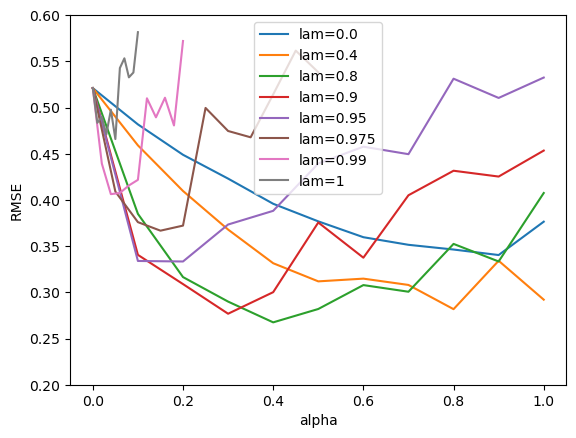

In [6]:
rmse_off_line = sweep(OffLine, lambdas, alphas)

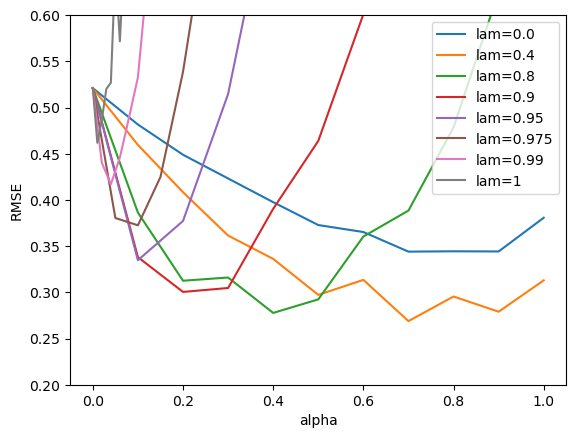

In [7]:
rmse_td = sweep(TemporalDifferenceLambda, lambdas, alphas)
#the RMSE may explode with too big alphas especially when lambda is large